In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# SIGINT Analysis in Python

*Tags: Inteliigence, NLP, Signals, COMINT, ELINT, Radar*

## Contents
1. Data Overview and Exploration
    - What type of signals did we receive?
    - What source and targets are most active?
2. Identify Entities
    - What entities are communicating
    - What is the relationship between entities
3. Message Prioritization
    - What is the sentiment of each message
    - Do any keywords exist in messages
    - Do any strange patterns exist
4. Concluding Analysis


In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.head()

,Signal ID,Signal Type,Frequency,Modulation,Encryption,Source,Destination,Content
0,S1,COMINT,2.4 GHz,FM,RSA,A1,A2,“Alpha Two sitrep?”
1,S2,ELINT,10 GHz,AM,NaN,R1,-,Radar pulse
2,S3,COMINT,5 GHz,QPSK,AES,B1,B2,"“Bravo One to Bravo Two, we have a target in s..."
3,S4,ELINT,15 GHz,FSK,NaN,R2,-,Radar sweep
4,S5,COMINT,3 GHz,PSK,RSA,C1,A1,"“Charlie One to Alpha One, we are under attack!”"


In [6]:
df.describe()

,Signal ID,Signal Type,Frequency,Modulation,Encryption,Source,Destination,Content
count,35,35,35,35,14,35,22,35
unique,35,2,21,10,5,21,9,29
top,S1,COMINT,2.4 GHz,QAM,DES,A1,A1,Radar chirp
freq,1,18,6,8,5,3,6,3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Signal ID    35 non-null     object
 1   Signal Type  35 non-null     object
 2   Frequency    35 non-null     object
 3   Modulation   35 non-null     object
 4   Encryption   14 non-null     object
 5   Source       35 non-null     object
 6   Destination  22 non-null     object
 7   Content      35 non-null     object
dtypes: object(8)
memory usage: 2.3+ KB


From the above summaries we can see there are a few attributes that have null entries. We know this because we have 35 rows total and some values are less than 35. 

We can make our data more readable by replacing some nulls with domain friendly language. For example, we can replace null values in the Encryption column with the value "Unecnrypted" or "Unknown".

*Note: that for some data nulls are appropriate. Destination being null is valid is the source is not transmitting a message to anyone but just creating a signal based on an action.*

In [8]:
#data prep

#replace NaN values in Encryption column with the value 'Unencrypted'
df.Encryption = df['Encryption'].fillna("Unencrypted")

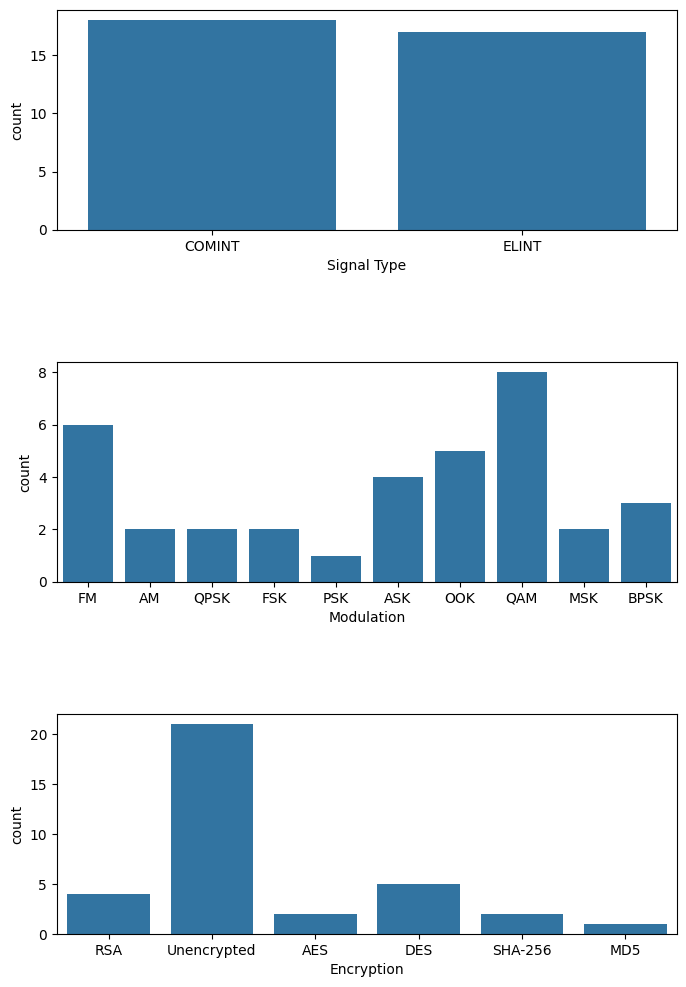

In [9]:
# visualize the signal types and encryption types present in the data.
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(8,12))

# get count by Signal Type
sns.countplot(data = df, x='Signal Type', ax=axes[0])

# get count by Modulation
sns.countplot(data = df, x='Modulation', ax=axes[1])

# get count by Encryption type
sns.countplot(data = df, x='Encryption', ax=axes[2])

plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show()


Analysis:
- About half our signals are COMINT messages and half are ELINT
- There is a wide range of modulation types but QAM makes up the majority followed by FM
- Most signals are unencrypted while DES is the most common encryption. There is also one MD5 encrypted message.

# Entity Identification

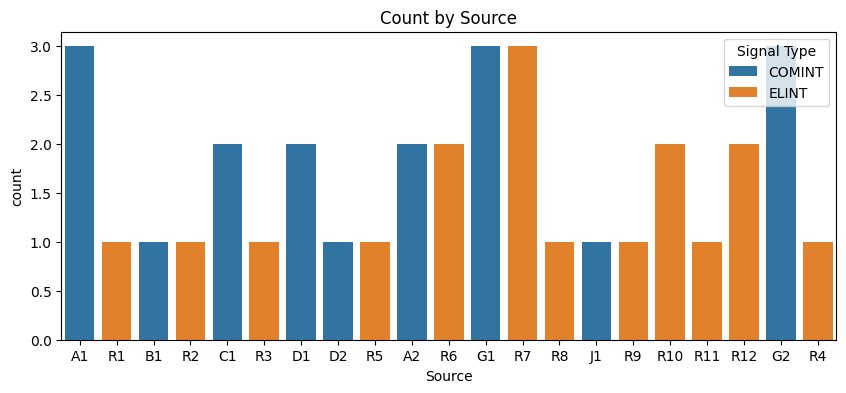

In [10]:
# What sources are most active.
fig = plt.figure(figsize=(10,4))

axes = sns.countplot(data=df, x='Source', hue='Signal Type')
axes.set_title('Count by Source')


plt.show()

From the plot above we can see that all ELINT signals are from sources that start with the letter R. All our COMINT messages are from sources labeled A, B, C, D, G, and J. 

This may be useful later. 

Additionally, there are more messages from source A1, G1, and G2. R7 also emits the most signals from ELINT messages.

G1 and G2 have the most messages indicating there may be some importance to G sources. 

In [11]:
source_count_df = df.groupby(['Signal Type', 'Source'])['Source'].count(). \
    reset_index(name='Signal Count'). \
    sort_values(by=['Signal Type', 'Signal Count'], ascending=False)

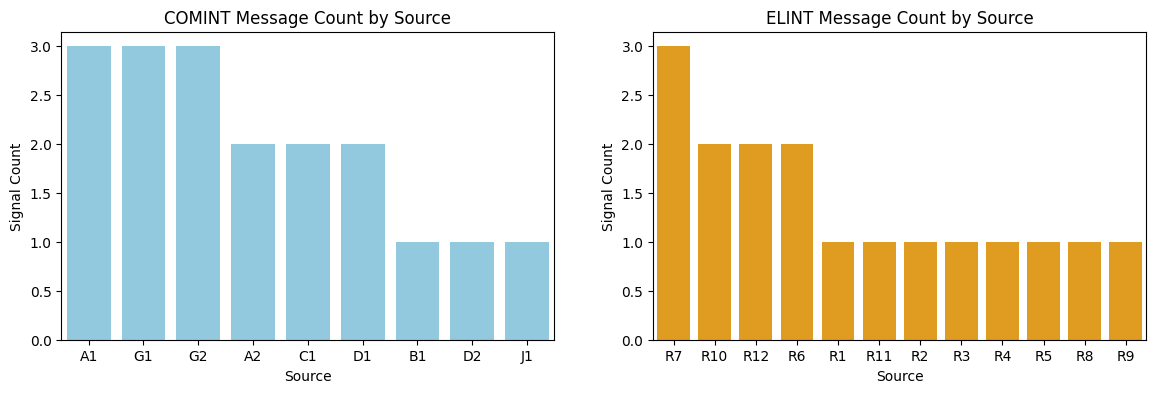

In [12]:
# visualize the sources by activity and signal type.
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,4))

# get count for COMINT
sns.barplot(data = source_count_df[source_count_df['Signal Type']=='COMINT'], x='Source', y='Signal Count',color = 'skyblue', ax=axes[0])

# get count for ELINT
sns.barplot(data = source_count_df[source_count_df['Signal Type']=='ELINT'], x='Source', y='Signal Count', color='orange', ax=axes[1])

plt.subplots_adjust(wspace=0.2, hspace=0.2)

axes[0].set_title("COMINT Message Count by Source")
axes[1].set_title("ELINT Message Count by Source")

plt.show()

Let's look at the Target/Destination column next.

In [13]:
df['Destination'].unique()

array(['A2', '-', 'B2', 'A1', 'C1', 'D1', nan, 'G2', 'J2', 'G1'],
      dtype=object)

None of the R* sources send signals to another entity. If we look at our ELINT signals message content, we can see that these rows are all radar noises. This is useful but there is little more to analyze. 

In [14]:
df[df['Signal Type'] == 'ELINT'].Content

1                          Radar pulse
3                          Radar sweep
5                          Radar burst
9              Radar frequency hopping
11                         Radar chirp
13                 Radar doppler shift
14                         Radar burst
15                         Radar chirp
16               Radar bistatic signal
18    Radar inverse synthetic aperture
19             Radar passive detection
20              Radar active detection
22                  Radar noise signal
27                  Radar noise signal
28                         Radar chirp
33             Radar passive detection
34                 Radar doppler shift
Name: Content, dtype: object

The rest of this analysis will focus on the COMINT signals only. 

In [15]:
#create dataframe without radar noise
comint_df = df[df['Signal Type'] == 'COMINT']
comint_df.head()

,Signal ID,Signal Type,Frequency,Modulation,Encryption,Source,Destination,Content
0,S1,COMINT,2.4 GHz,FM,RSA,A1,A2,“Alpha Two sitrep?”
2,S3,COMINT,5 GHz,QPSK,AES,B1,B2,"“Bravo One to Bravo Two, we have a target in s..."
4,S5,COMINT,3 GHz,PSK,RSA,C1,A1,"“Charlie One to Alpha One, we are under attack!”"
6,S7,COMINT,4 GHz,OOK,DES,D1,C1,"“Delta One to Charlie One, moving to your posi..."
7,S8,COMINT,4 GHz,QAM,Unencrypted,D1,A1,"Alpha One, Delta One is moving to support Char..."


Let's look at the relationship between Sources and Destinations for the messages. This is a good use case for a network visual. 

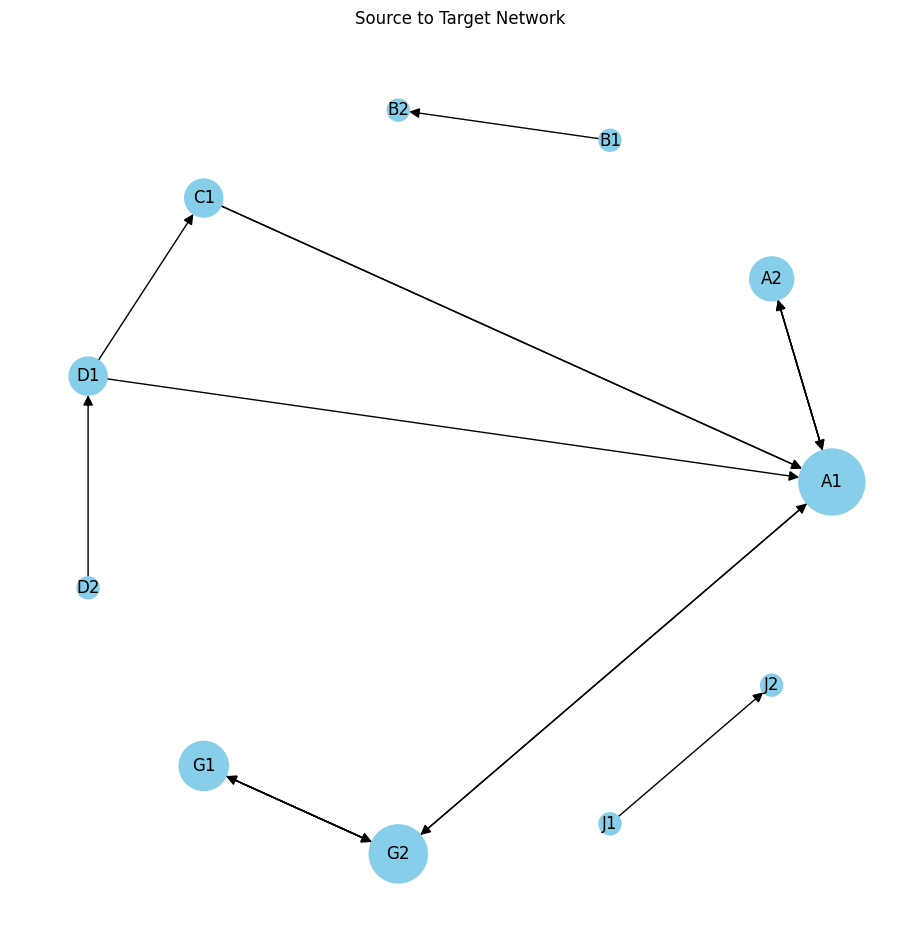

In [16]:
#plot visual showing relationship between sources and destinations
plt.figure(figsize=(9,9))

#create graph object
graph = nx.from_pandas_edgelist(comint_df,
                                 'Source',
                                   'Destination',
                                   create_using=nx.MultiDiGraph)


#node sizes (a destination node will be larger if it received more signals)
degree = dict(graph.degree)
node_size = [v * 250 for v in degree.values()]

# Create a layout for the nodes 
pos = nx.spring_layout(graph, k=1.0)  # Change 'k' to space out the nodes more
pos = nx.shell_layout(graph)
pos = nx.circular_layout(graph)



#plot graph
nx.draw(G=graph, pos=pos,with_labels=True,
         node_color='skyblue', node_size=node_size,
           edge_color='k', arrowsize=15, arrowstyle='-|>')

plt.title("Source to Target Network")
plt.show()

Most of the traffic converges on A1. When we look at the actual message content we can see that this entity is called "Alpha One". Due to the high number of in-bound messages we can speculate that Alpha One is a command unit. 

Another point to note is J (Juliet) units and B (Bravo) units do not communicate with the larger org and may be independent of the larger unit comprised of Alpha, Golf, Delta, and Charlie units. 

Golf Two received alot of communications and communicated back with Golf One. It may be worth deeper analysis. 

In [17]:
comint_df.loc[:, 'Interaction'] = comint_df['Source'] + comint_df['Destination']

C:\Users\grant\AppData\Local\Temp\ipykernel_2492\172734353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comint_df.loc[:, 'Interaction'] = comint_df['Source'] + comint_df['Destination']


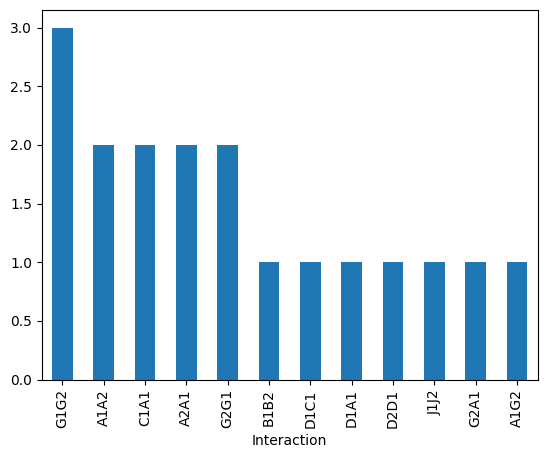

In [18]:
comint_df.Interaction.value_counts().plot(kind='bar')
plt.show()

In [19]:
pd.set_option('display.max_colwidth', 150)

comint_df[(comint_df.Source == 'G2') | (comint_df.Destination == 'G2')][['Source', 'Destination', 'Content']]

,Source,Destination,Content
12,G1,G2,"“Golf One to Golf Two, we have intercepted a hostile signal.”"
23,G2,G1,"""Roger, send for interpretation."""
24,G1,G2,"""Transmitting now over digital. Acknowledge when received."""
25,G1,G2,"""2ddb41e689a4c09debd805f1b5c3"""
26,G2,G1,"""Acknowledge Golf One. Message received. Golf two out."""
29,G2,A1,"""Alpha One, be advised hostile communications indicate a major offensive is planned in your AO. Advise you increase local security checks and advi..."
30,A1,G2,"""Understood Alpha One. Recalling Alpha Two to base."""


Analysis:
- Golf one and two appear to be a SIGINT unit that is listening for hostile signals 
    - Golf One may be the technical unit actually intercepting and listening for signals
    - Golf Two appears to be the analysis unit that extracts valuable intel from the interepted signal
- After intercepting a hostile signal, Golf One sends the signal to Golf Two for analysis
- Golf Two decodes the message and relays the intel back to command at Alpha One.
- The encrypted hostile message is included in S25.

Now we know which units are listening. This could be useful for counterintelligence operations.

# Message Prioritization

Currently the messages are given in the order we intercepted them. While this is useful and provides some chronological flow, without timestamps it's hard to know the exact order of events. Let's assume these messages are in chornological order. 

What we really care about is what messages are important. When a set of signals comes in, it would be useful to have them classified by importance and then put those messages at the top of our queue for immediate analysis. 

We can try to accomplish this with natural language processing using sentiment and keyword recognition. 

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer 
import nltk

nltk.download([
     "names",
     "stopwords",
     "state_union",
     "twitter_samples",
     "movie_reviews",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
])

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up

True

In [21]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [36]:
for message in comint_df.Content:
    print(f'{message} ---- {sentiment_analyzer.polarity_scores(message)["compound"]}')

“Alpha Two sitrep?” ---- 0.0
“Bravo One to Bravo Two, we have a target in sight.” ---- 0.0
“Charlie One to Alpha One, we are under attack!” ---- 0.0
“Delta One to Charlie One, moving to your position. ETA 5 minutes.” ---- 0.0
Alpha One, Delta One is moving to support Charlie one. ---- 0.4019
“Delta Two to Delta One, we have secured the area North of Charile One.” ---- 0.4019
“Alpha one, alpha two is proceeding to checkpoint 1.” ---- 0.0
“Golf One to Golf Two, we have intercepted a hostile signal.” ---- -0.3818
“Juliet One to Juliet Two, radio check?” ---- 0.0
“Charlie One to Alpha One area now secure. Significant hostile casualties and damage to local facilities. Requesting medical and engineering support to our position.” ---- 0.0258
"Roger, send for interpretation." ---- 0.0
"Transmitting now over digital. Acknowledge when received." ---- 0.0
"2ddb41e689a4c09debd805f1b5c3" ---- 0.0
"Acknowledge Golf One. Message received. Golf two out." ---- 0.0
"Alpha One, be advised hostile communi

Using the pre-built sentiment analyzer we don't get much useful information. The longer messages are given a rating other than neutral but this isn't super helpful. 

One thing we could do is scrape other more specific datasources such as 911 transcripts and build our own corpus that would do a better job of identifying message sentiment. 

However for simplicity sake, we can try keyword identification which will give us more control over what is flagged. 

In [62]:
# create keyword list
keywords = [
    "hostile",
    "attack",
    "help",
    "emergency",
    "enemy",
    "KIA",
    "urgent",
    "priority",
    "wounded",
    "injury",
    "injuries"
    "intelligence"
    "signal",
    "offensive",
    "medical",
    "security"
]

In [63]:
keyword_analysis_counts = dict.fromkeys(comint_df['Signal ID'], 0)

for index ,signal in comint_df.iterrows():
    tokens = nltk.word_tokenize(signal['Content'])
    if any(keyword in tokens for keyword in keywords):
        print(f"Keyword(s) found in sentence: '{signal['Content']}'")
        for keyword in keywords:
            keyword_analysis_counts[signal['Signal ID']] += tokens.count(keyword)


Keyword(s) found in sentence: '“Charlie One to Alpha One, we are under attack!”'
Keyword(s) found in sentence: '“Golf One to Golf Two, we have intercepted a hostile signal.”'
Keyword(s) found in sentence: '“Charlie One to Alpha One area now secure. Significant hostile casualties and damage to local facilities. Requesting medical and engineering support to our position.”'
Keyword(s) found in sentence: '"Alpha One, be advised hostile communications indicate a major offensive is planned in your AO. Advise you increase local security checks and advise non-essential personal to shelter in place."'
Keyword(s) found in sentence: '"Alpha Two, return to base immediately to assist with security efforts."'


In [80]:
comint_df = comint_df.assign(Priority = keyword_analysis_counts.values())

In [89]:
comint_df[comint_df.Priority > 0].sort_values('Priority', ascending=False)[['Signal ID', 'Content', 'Priority']]

,Signal ID,Content,Priority
29,S30,"""Alpha One, be advised hostile communications indicate a major offensive is planned in your AO. Advise you increase local security checks and advi...",3
21,S22,“Charlie One to Alpha One area now secure. Significant hostile casualties and damage to local facilities. Requesting medical and engineering suppo...,2
4,S5,"“Charlie One to Alpha One, we are under attack!”",1
12,S13,"“Golf One to Golf Two, we have intercepted a hostile signal.”",1
31,S32,"""Alpha Two, return to base immediately to assist with security efforts.""",1


In [91]:
comint_df[comint_df.Priority == 0].sort_values('Priority', ascending=False)[['Signal ID', 'Content']]

,Signal ID,Content
0,S1,“Alpha Two sitrep?”
2,S3,"“Bravo One to Bravo Two, we have a target in sight.”"
6,S7,"“Delta One to Charlie One, moving to your position. ETA 5 minutes.”"
7,S8,"Alpha One, Delta One is moving to support Charlie one."
8,S9,"“Delta Two to Delta One, we have secured the area North of Charile One.”"
10,S11,"“Alpha one, alpha two is proceeding to checkpoint 1.”"
17,S18,"“Juliet One to Juliet Two, radio check?”"
23,S24,"""Roger, send for interpretation."""
24,S25,"""Transmitting now over digital. Acknowledge when received."""
25,S26,"""2ddb41e689a4c09debd805f1b5c3"""
